# Project Overview
This project explores the application of Generative Adversarial Networks (GANs) to generate synthetic images in the style of Monet. The dataset used for this task consists of 300 real Monet paintings, sourced from the I’m Something of a Painter Myself competition on Kaggle. Using GAN techniques, I aimed to train a model capable of producing semi-Monet-like images by leveraging two neural networks: a generator (the "art forger") and a discriminator (the "art critic").

The implementation was inspired by tutorials such as the Monet CycleGAN Tutorial by Amy Jang and the DCGAN for Face Generation tutorial by François Chollet. These resources provided foundational architectures and methodologies that I adapted and experimented with to achieve my results.

# Environment Setup
The project was developed and executed in a Google Colab environment connected to an NVIDIA A100 GPU, which significantly accelerated the training process. During experimentation, I also tested the code on a TPU v6e-1, but found the GPU to be faster for this specific task. The TensorFlow framework (version 2.19.0) was used for implementing and training the GAN models.

# GAN Architecture
## 1. Discriminator
The discriminator network was built using a Deep Convolutional GAN (DCGAN) architecture. Its primary role is to distinguish between real Monet images and those generated by the generator. Key features of the discriminator include:

- Progressive Downsampling: The input image dimensions are progressively divided by 2 through convolutional layers, resulting in an 8x8x1024 feature map.
- Activation Functions: Leaky ReLU activation functions were used throughout the network to prevent vanishing gradients.
- Batch Normalization: Applied after convolutional layers to stabilize gradient updates during training.
- Output Layer: The final layer flattens the feature map and outputs a single node, representing the probability of the input being real or fake.

### Model Summary:
Total Params: 11,219,393
Trainable Params: 11,215,553
Non-Trainable Params: 3,840

## 2. Generator
The generator network was designed to produce realistic Monet-style images from random noise vectors. It uses transposed convolutional layers to upscale the latent vector into a 256x256 RGB image. Key features include:

- Upsampling Layers: Transposed convolutions increase the spatial dimensions of the latent vector while reducing the number of channels.
- Activation Functions: Leaky ReLU activations were used in intermediate layers, with a Tanh activation in the output layer to ensure pixel values lie in the range [-1, 1].
- Batch Normalization: Applied to stabilize training and improve convergence.

# Training Process
## 1. Training Pipeline
The training pipeline involved alternating between updating the discriminator and generator weights. The process can be summarized as follows:

A. Discriminator Training:
- The discriminator is trained on a batch of real Monet images and a batch of fake images generated by the generator.
- The loss function used was binary cross-entropy, which penalizes incorrect classifications.
B. Generator Training:
- After freezing the discriminator's weights, the generator is trained to produce images that fool the discriminator.
- The generator's loss is based on how well it deceives the discriminator.

## 2. Hyperparameter Tuning
Several hyperparameters were experimented with to improve performance:

- Learning Rates: Different learning rates were tested for both the generator and discriminator optimizers (Adam optimizer with beta_1=0.5).
- Latent Dimension: The size of the random noise vector was adjusted to balance complexity and quality.
- Batch Size: Smaller batch sizes were used to stabilize training.

## 3. Monitoring Progress
To monitor the generator's progress, a callback (GANMonitor) was implemented to save sample images at the end of each epoch. This allowed me to visually assess the evolution of the generated images over time.

# Results and Challenges
## 1. Results
After training for 500 epochs, the generator produced semi-Monet-like images that captured some stylistic elements of the original paintings. However, achieving high-quality results proved challenging due to the limited size of the dataset (only 300 real images).

Example Outputs:


Generated Image 1:
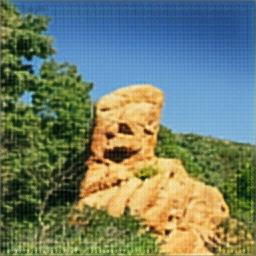

Generated Image 2: 
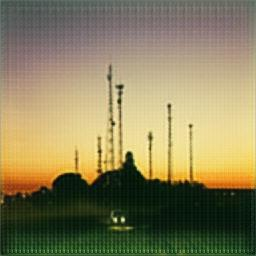

## 2. Challenges
- Dataset Size: With only 300 real Monet images, the model struggled to generalize effectively.
- Mode Collapse: At times, the generator would produce similar-looking images, indicating mode collapse.
- Submission Issues: Despite generating 7,000 images for the Kaggle competition, I encountered errors when submitting the images.zip file, preventing me from evaluating the model's performance on the leaderboard.

# Conclusion
This project demonstrated the potential of GANs to generate synthetic Monet-style images, even with a small dataset. While the results were promising, further improvements could be achieved by:

- Using data augmentation techniques to artificially expand the dataset.
- Experimenting with advanced architectures like CycleGAN or StyleGAN.
- Fine-tuning hyperparameters and training for more epochs.

Although I faced challenges during the submission process, the experience provided valuable insights into the intricacies of GAN training and optimization.

# Code Highlights
## 1. DCGAN Implementation
The DCGAN class was implemented by subclassing keras.Model and overriding the train_step method. This allowed for a clean and modular training loop.

class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        # Training logic for discriminator and generator
        ...
        ...
## 2. Image Generation
To generate the final 7,000 images for submission, random noise vectors were passed through the trained generator. The images were upscaled from 128x128 to 256x256 and saved in a JPEG format.

latent_vectors = tf.random.normal(shape=(7000, latent_dim))
generated_images = generator(latent_vectors)
upscaled_images = tf.image.resize(generated_images, [256, 256])
for i, img_tensor in enumerate(upscaled_images):
    img = keras.utils.array_to_img(img_tensor)
    img.save(f"images/generated_image_{i+1}.jpg")
    
# Future Work
- Explore CycleGAN for unpaired image-to-image translation.
- Experiment with StyleGAN for higher-resolution and more detailed outputs.
- Investigate techniques like transfer learning to leverage pre-trained models.

In [ ]:
# Imports
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import array_to_img
import zipfile

# --- GPU Setup ---
AUTO = tf.data.AUTOTUNE

# Ensure TensorFlow uses GPU (if available)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Paths for TFRecords
monet_tfrec = '/kaggle/input/gan-getting-started/monet_tfrec'
photo_tfrec = '/kaggle/input/gan-getting-started/photo_tfrec'

# Constants
IMAGE_SIZE = (256, 256)
IMAGE_SHAPE = (256, 256, 3)
BATCH_SIZE = 1
EPOCHS = 20 
LAMBDA = 10

# --- Custom InstanceNorm (instead of tfa.layers.InstanceNormalization) ---
class InstanceNormalization(layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(
            shape=(input_shape[-1],),
            initializer="ones",
            trainable=True
        )
        self.beta = self.add_weight(
            shape=(input_shape[-1],),
            initializer="zeros",
            trainable=True
        )
        super(InstanceNormalization, self).build(input_shape)

    def call(self, x):
        mean, var = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        return self.gamma * (x - mean) / tf.sqrt(var + self.epsilon) + self.beta

# Function to parse TFRecords
def parse_tfrecord(example_proto):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example_proto, feature_description)
    img = tf.io.decode_jpeg(example['image'], channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = (tf.cast(img, tf.float32) / 127.5) - 1.0  # normalize [-1,1]
    return img

# Load datasets
monet_files = tf.io.gfile.glob(os.path.join(monet_tfrec, "*.tfrec"))
photo_files = tf.io.gfile.glob(os.path.join(photo_tfrec, "*.tfrec"))

monet_dataset = tf.data.TFRecordDataset(monet_files).cache()
monet_dataset = monet_dataset.map(parse_tfrecord, num_parallel_calls=AUTO)
monet_dataset = monet_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTO)

photo_dataset = tf.data.TFRecordDataset(photo_files).cache()
photo_dataset = photo_dataset.map(parse_tfrecord, num_parallel_calls=AUTO)
photo_dataset = photo_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTO)

# --- Define Models ---
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_instancenorm:
        result.add(InstanceNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same', kernel_initializer=initializer,
                                      use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def Generator():
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(IMAGE_SHAPE[2], 4,
                                   strides=2,
                                   padding='same',
                                   kernel_initializer=initializer,
                                   activation='tanh')
    concat = layers.Concatenate()
    inputs = layers.Input(shape=IMAGE_SHAPE)
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return Model(inputs=inputs, outputs=x, name="Generator")

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = layers.Input(shape=IMAGE_SHAPE, name='discriminator_input')
    x = inputs
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(norm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)
    return Model(inputs=inputs, outputs=last, name="Discriminator")

# --- Loss and Optimizers ---
loss_obj = keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_img, fake_img):
    real_loss = loss_obj(tf.ones_like(real_img), real_img)
    fake_loss = loss_obj(tf.zeros_like(fake_img), fake_img)
    return tf.cast(real_loss, tf.float32) + tf.cast(fake_loss, tf.float32)

def generator_loss(fake_img):
    return tf.cast(loss_obj(tf.ones_like(fake_img), fake_img), tf.float32)

def cycle_loss(real_img, cycled_img):
    return LAMBDA * tf.reduce_mean(tf.abs(tf.cast(real_img, tf.float32) - tf.cast(cycled_img, tf.float32)))

def identity_loss(real_img, same_img):
    return LAMBDA * 0.5 * tf.reduce_mean(tf.abs(tf.cast(real_img, tf.float32) - tf.cast(same_img, tf.float32)))

monet_generator_optimizer = Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = Adam(2e-4, beta_1=0.5)
monet_discriminator_optimizer = Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = Adam(2e-4, beta_1=0.5)

# Instantiate models
monet_generator = Generator()
photo_generator = Generator()
monet_discriminator = Discriminator()
photo_discriminator = Discriminator()

# --- Training Step ---
@tf.function
def train_step(real_monet, real_photo):
    real_monet = tf.cast(real_monet, tf.float32)
    real_photo = tf.cast(real_photo, tf.float32)
    
    with tf.GradientTape(persistent=True) as tape:
        fake_monet = monet_generator(real_photo, training=True)
        cycled_photo = photo_generator(fake_monet, training=True)
        fake_photo = photo_generator(real_monet, training=True)
        cycled_monet = monet_generator(fake_photo, training=True)

        same_monet = monet_generator(real_monet, training=True)
        same_photo = photo_generator(real_photo, training=True)

        disc_fake_monet = monet_discriminator(fake_monet, training=True)
        disc_real_monet = monet_discriminator(real_monet, training=True)
        disc_fake_photo = photo_discriminator(fake_photo, training=True)
        disc_real_photo = photo_discriminator(real_photo, training=True)

        monet_gen_loss = generator_loss(disc_fake_monet)
        photo_gen_loss = generator_loss(disc_fake_photo)
        total_cycle_loss = cycle_loss(real_monet, cycled_monet) + cycle_loss(real_photo, cycled_photo)
        id_loss_monet = identity_loss(real_monet, same_monet)
        id_loss_photo = identity_loss(real_photo, same_photo)

        total_monet_gen_loss = monet_gen_loss + total_cycle_loss + id_loss_monet
        total_photo_gen_loss = photo_gen_loss + total_cycle_loss + id_loss_photo

        monet_disc_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        photo_disc_loss = discriminator_loss(disc_real_photo, disc_fake_photo)

    monet_gen_grads = tape.gradient(total_monet_gen_loss, monet_generator.trainable_variables)
    photo_gen_grads = tape.gradient(total_photo_gen_loss, photo_generator.trainable_variables)
    monet_disc_grads = tape.gradient(monet_disc_loss, monet_discriminator.trainable_variables)
    photo_disc_grads = tape.gradient(photo_disc_loss, photo_discriminator.trainable_variables)

    monet_generator_optimizer.apply_gradients(zip(monet_gen_grads, monet_generator.trainable_variables))
    photo_generator_optimizer.apply_gradients(zip(photo_gen_grads, photo_generator.trainable_variables))
    monet_discriminator_optimizer.apply_gradients(zip(monet_disc_grads, monet_discriminator.trainable_variables))
    photo_discriminator_optimizer.apply_gradients(zip(photo_disc_grads, photo_discriminator.trainable_variables))

    return total_monet_gen_loss, total_photo_gen_loss, monet_disc_loss, photo_disc_loss

# --- Training loop ---
monet_iterator = iter(monet_dataset)
photo_iterator = iter(photo_dataset)


for epoch in range(EPOCHS):  
    num_monet_samples = len(tf.io.gfile.glob(os.path.join(monet_tfrec, "*.tfrec")))
    num_photo_samples = len(tf.io.gfile.glob(os.path.join(photo_tfrec, "*.tfrec")))
    num_steps = min(num_monet_samples, num_photo_samples) // BATCH_SIZE
    
    for step in range(num_steps):
        try:
            monet_batch = next(monet_iterator)
            photo_batch = next(photo_iterator)
        except StopIteration:
            monet_iterator = iter(monet_dataset)
            photo_iterator = iter(photo_dataset)
            monet_batch = next(monet_iterator)
            photo_batch = next(photo_iterator)

        monet_gen_loss, photo_gen_loss, monet_disc_loss, photo_disc_loss = train_step(monet_batch, photo_batch)

    print(f"Epoch {epoch}/{EPOCHS}, Monet Gen Loss: {monet_gen_loss:.4f}, Photo Gen Loss: {photo_gen_loss:.4f}, Monet Disc Loss: {monet_disc_loss:.4f}, Photo Disc Loss: {photo_disc_loss:.4f}")

# --- Generate and save images ---
output_zip = '/kaggle/working/images.zip'
with zipfile.ZipFile(output_zip, 'w') as zipf:
    img_count = 0
    
    for batch in photo_dataset.repeat():
        if img_count >= 7000:
            break
            
        gen_imgs = monet_generator.predict(batch)
        for i in range(gen_imgs.shape[0]):
            img = (0.5 * gen_imgs[i] + 0.5) * 255.0
            img = array_to_img(img)
            img_path = f'monet_generated_{img_count}.jpg'
            img.save(img_path)
            zipf.write(img_path)
            os.remove(img_path)
            img_count += 1

print(f"Generated {img_count} images into images.zip")

2025-10-10 13:10:02.232518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760101802.499301      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760101802.580291      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available:  0


2025-10-10 13:10:18.511192: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 0/20, Monet Gen Loss: 9.1083, Photo Gen Loss: 9.5203, Monet Disc Loss: 1.6498, Photo Disc Loss: 1.9118
Epoch 1/20, Monet Gen Loss: 11.6477, Photo Gen Loss: 13.1647, Monet Disc Loss: 1.5657, Photo Disc Loss: 1.5368
Epoch 2/20, Monet Gen Loss: 7.6346, Photo Gen Loss: 8.4061, Monet Disc Loss: 1.4548, Photo Disc Loss: 1.3620
Epoch 3/20, Monet Gen Loss: 7.9636, Photo Gen Loss: 8.2809, Monet Disc Loss: 1.4632, Photo Disc Loss: 1.4575
Epoch 4/20, Monet Gen Loss: 12.8825, Photo Gen Loss: 12.2502, Monet Disc Loss: 1.4215, Photo Disc Loss: 1.4952
Epoch 5/20, Monet Gen Loss: 5.8585, Photo Gen Loss: 5.7591, Monet Disc Loss: 1.3863, Photo Disc Loss: 1.4289
Epoch 6/20, Monet Gen Loss: 8.1552, Photo Gen Loss: 8.5259, Monet Disc Loss: 1.4813, Photo Disc Loss: 1.3684
Epoch 7/20, Monet Gen Loss: 5.5806, Photo Gen Loss: 5.5459, Monet Disc Loss: 1.4193, Photo Disc Loss: 1.3336
Epoch 8/20, Monet Gen Loss: 7.1603, Photo Gen Loss: 7.1885, Monet Disc Loss: 1.3988, Photo Disc Loss: 1.4163
Epoch 9/20, Mon